### notebook to check if our satellite track merger is screwing things up

we're using events from /FOM_merge&fit/

In [18]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'
import IC.invisible_cities.io.dst_io                           as     dstio
import IC.invisible_cities.io.mcinfo_io as mcio
from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.special as special
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

In [9]:
def collate_ports(path_array):
    '''
    Collect individual ports and merge the information

    Args:
        path_array          :           an array of folder paths to h5 files
                                        respective of the multiple ports

    
    Returns:
        array               :           output of collective ports
    '''

    # strip array except from port information
    port_id = [x.split('PORT_')[1][:2] for x in path_array]

    for i in range(len(path_array)):
        print("Porting {}".format(path_array[i]))
        if (i==0):
            x = (func.load_data(path_array[i]))
            tracks = x[0]
            #particles = x[1]
            # match tracks for particle
            #particles['event_id'] = particles['event_id'] * ((i+1)*2)
            # add on the column for port ID
            tracks['PORT'] = str(port_id[i])
        else:
            nu_x = (func.load_data(path_array[i]))
            nu_tracks = nu_x[0]
            #nu_particles = nu_x[1]
            print("Tracks: {}".format(func.len_events(nu_tracks)))
            # multiply the events numbers to avoid overlap
            nu_tracks['event'] = nu_tracks['event'] * (i+1)
            nu_tracks['PORT'] = str(port_id[i])
            #nu_particles['event_id'] = nu_particles['event_id'] * ((i+1)*2)


            tracks = tracks.append(nu_tracks)
            #particles = particles.append(nu_particles)

        print("Done! Tracks available: {}".format(func.len_events(tracks)))
    
    return tracks

def positron_ports(path_array):
    '''
    Collect positron events from multiple ports.
    Bespoke, use with care.
    '''

    for i in range(len(path_array)):
        print("Loading positrons from {}".format(path_array[i]))
        if (i==0):
            posi = func.positron_scraper(path_array[i])
            # multiply the event numbers to match track values
            posi['event_id'] = posi['event_id'] * ((i+1)*2)
        else:
            nu_posi = func.positron_scraper(path_array[i])
            print("Positron events: {}".format(func.len_events(nu_posi, tag = 'event_id')))
            # multiple the event numbers to avoid overlap, the *2 is to match it with the tracking values
            nu_posi['event_id'] = nu_posi['event_id'] * ((i+1)*2)
            posi = posi.append(nu_posi)
        print("Port finished! Tracks available: {}".format(func.len_events(posi, tag = 'event_id')))
    
    return posi


# a modified version of the positron scraper
def MC_collector(data_path, event_list, save = False):
    '''
    a modified version of the positron scraper
    that only collects events found within the event list
    this only works for port 1a at the moment, because I
    would need to add an event/port mapping function and im too lazy
    '''



     # collect all filenames
    try:
        file_names = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and f.endswith('.h5')]
    except:
        print("File path incorrect, please state the correct file path\n(but not any particular folder!)")


    # read in a singular file to collect the column titles
    
    MC_df_single = pd.read_hdf(data_path + file_names[0], 'MC/particles')

    MC_df = []
    pos_df = pd.DataFrame(columns = MC_df_single.columns)
    eventmap = []


    i = 0
    

    # how much you chunk your data
    chunker = np.floor(len(file_names)*0.1)

    # chunk file_names
    
    for file in file_names:
        file_path = data_path + file

        # load in file
        MC_df_temp = pd.read_hdf(file_path, 'MC/particles')
        MC_df.append(MC_df_temp)
        eventmap.append(mcio.load_eventnumbermap(file_path).set_index('nexus_evt'))


        i += 1

        # chunk checker, every time you hit a certain chunk,
        # collect the positron events and wipe the df
        if ((i%chunker) == 0):
            #print("Chunking at event {}!".format(i))
            # concat the list
            MC_df = pd.concat(MC_df, axis = 0, ignore_index = True)
            #print("Post concat")
            #display(MC_df)
            # alter all the event list numbers by multiples of 2
            MC_df['event_id'] = MC_df['event_id'] * 2
            pos_data = MC_df[MC_df['event_id'].isin(event_list)]

            
            #display(pos_data)
            #print(type(pos_data))
            # collect positron events into df
            pos_df = pos_df.append(pos_data)
            #print("{} positron events found\n{} positron events total".format(pos_data.shape[0],pos_df.shape[0]))
            #display(pos_df)

            # make space
            MC_df = []

    if (save == True):
        pos_df.to_hdf('positrons.h5', key = 'pos', mode = 'w')

    return pos_df


In [4]:
folder_paths = ['../FOM_merge&fit/75_9e-3/PORT_1a/isaura/', '../FOM_merge&fit/75_9e-3/PORT_1b/isaura/', '../FOM_merge&fit/75_9e-3/PORT_2a/isaura/']
x = collate_ports(folder_paths)
full_tracks = x


Porting ../FOM_merge&fit/75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting ../FOM_merge&fit/75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting ../FOM_merge&fit/75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973


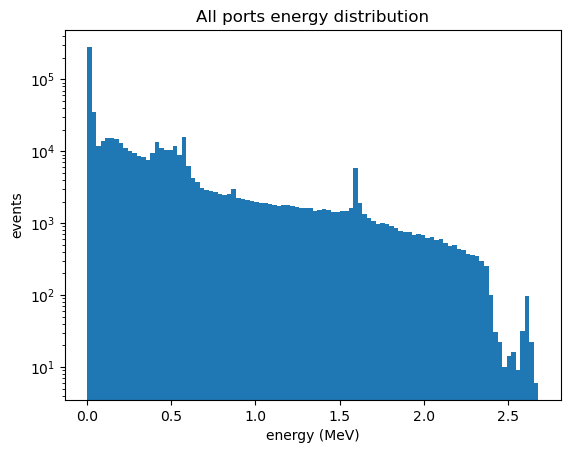

In [6]:
func.plot_hist(full_tracks, binning = 100, title='All ports energy distribution')

here, we remove the events, rather than applying the satellite track save

In [7]:
# traditional method
satellite_removal_tracks = func.remove_low_E_events(full_tracks)

# the clean removal method
low_e_tracks = full_tracks[full_tracks.energy > 0.05]


/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remove_low_E['numb_of_tracks'] = remove_low_E['event'].map(event_counts)


In [8]:
# apply cuts
remove_cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

merge_cut_tracks = func.apply_cuts(satellite_removal_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)

Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.24 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.56 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.75 %
Absolute Cut efficiency:
Efficiency: 7.61 %
Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 40.72 %
Absolute Cut efficiency:
Efficiency: 40.72 %
One track cut
Relative Cut efficiency:
Efficiency: 64.68 %
Absolute Cut efficiency:
Efficiency: 53.25 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.55 %
Absolute Cut efficiency:
Efficiency: 71.49 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.78 %
Absolute C

In [16]:
print(merge_cut_tracks[0])

           event  trackID    energy      length  numb_of_voxels  numb_of_hits  \
107      5080086        0  1.683154  324.712905              75          7056   
737      5080582        0  1.597251  142.007874              59          6551   
854      5080676        0  1.594962  141.841206              50          7768   
984      1740022        0  1.595983  240.220791              71          7411   
1054     1740082        0  1.619501  331.972634              74          7845   
...          ...      ...       ...         ...             ...           ...   
658487  14821002        0  1.597759  152.704345              55          6507   
658675  12180240        0  1.593503  168.933124              59          7329   
658853  12180756        0  1.597874   84.486164              43          8744   
658904  12180888        0  1.596929  178.966898              57          6689   
658978  12181110        0  1.596121  202.036913              72          8597   

        numb_of_tracks    x

In [19]:
# collect all the relevant events here
merge_events_np = merge_cut_tracks[0].event.to_numpy()

# load in MC data for port 1, and retain only the events
# that appear in the merged satellite tracks
particles = MC_collector(folder_paths[0], merge_events_np)

In [20]:
display(particles)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
3237,5080086,1,Tl208,True,0,397.275879,397.226379,530.329224,0.000000,397.275879,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,none,RadioactiveDecay
3238,5080086,4,e-,False,1,397.275879,397.226379,530.329224,0.000471,397.238525,...,-0.155843,0.036235,-1.045425,0.000000,-0.000000,0.000000,0.663579,0.650811,RadioactiveDecay,eIoni
3239,5080086,3,anti_nu_e,False,1,397.275879,397.226379,530.329224,0.000471,12500.000000,...,0.621529,-0.502757,0.317674,0.621529,-0.502757,0.317674,0.860220,16750.646484,RadioactiveDecay,Transportation
3240,5080086,2,Pb208[3475.078],False,1,397.275879,397.226379,530.329224,0.000471,397.275879,...,-0.465685,0.466521,0.727749,-0.000000,0.000000,0.000000,0.000002,0.000000,RadioactiveDecay,RadioactiveDecay
3241,5080086,6,gamma,False,2,397.275879,397.226379,530.329224,0.000471,405.200317,...,0.505929,-0.578456,-0.387270,0.000000,-0.000000,-0.000000,0.860554,23.081326,RadioactiveDecay,phot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814067,4060672,86,e-,False,65,-62.778000,196.446259,835.622742,2.263319,-62.778736,...,-0.005284,0.009032,-0.021361,-0.000000,-0.000000,-0.000000,0.000553,0.003024,phot,eIoni
814068,4060672,85,e-,False,65,-62.778000,196.446259,835.622742,2.263319,-62.783031,...,-0.029379,0.039422,0.032796,0.000000,-0.000000,-0.000000,0.003406,0.044558,phot,eIoni
814069,4060672,84,e-,False,65,-62.778000,196.446259,835.622742,2.263319,-62.782715,...,-0.041870,0.027957,0.018076,0.000000,0.000000,-0.000000,0.002792,0.027970,phot,eIoni
814070,4060672,64,e-,False,38,-33.634335,182.722595,809.283997,2.106826,-33.638508,...,-0.026596,0.101011,-0.132229,0.000000,0.000000,-0.000000,0.027067,1.260876,eIoni,eIoni


In [61]:
# need to collect from particles only those from the same mother id as the positron
positron_events = particles[particles['particle_name'] == 'e+']
display(positron_events)
# create tuples of only the event id and mother id
mother_event = list(zip(positron_events.event_id, positron_events.mother_id))
print(mother_event)



'''
positron_evts = particles[particles['particle_name'] == 'e+']
mother_ids = positron_evts.mother_id

posi_labels = positron_evts.event_id.to_numpy()

signal_events = particles[particles.event_id.isin(posi_labels)]
display(signal_events)
# sum the total energy of each event
#summed_E = particles.groupby('event_id')['kin_energy'].sum().reset_index()
#display(summed_E)
'''
display(particles[((particles.event_id == 800010) & (particles.mother_id == 29))])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
22812,5080582,40,e+,False,38,344.132690,70.319809,703.978027,1.242562,308.336365,...,-0.105922,-1.027007,0.525102,-0.0,0.0,0.0,0.755024,220.214523,conv,annihil
26339,5080676,36,e+,False,34,206.829880,200.574570,475.604889,0.932490,269.931305,...,-0.892218,-0.267511,1.077839,0.0,0.0,-0.0,1.002432,292.755707,conv,annihil
30339,1740022,53,e+,False,51,206.539032,63.175610,417.321869,1.344800,198.537872,...,-0.355469,-0.142593,-0.455008,-0.0,0.0,0.0,0.273121,43.223972,conv,annihil
40751,1740272,58,e+,False,56,-117.577866,78.576538,455.516266,2.032006,-127.997086,...,-1.683233,0.220883,0.120944,0.0,0.0,0.0,1.266024,305.107758,conv,annihil
51246,1740538,23,e+,False,21,-78.395592,-235.144211,515.272034,2.636652,42.846317,...,-0.935543,-0.948820,-0.658904,0.0,0.0,-0.0,1.060871,296.485962,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801326,4060350,24,e+,False,22,88.587334,47.950806,530.350708,1.547356,88.997719,...,0.219269,0.586493,0.312772,0.0,0.0,0.0,0.355603,65.218979,conv,annihil
805963,4060472,33,e+,False,31,152.282867,119.753876,253.005630,1.551216,107.279686,...,-0.822312,-0.580125,-0.709536,0.0,-0.0,0.0,0.822156,248.743088,conv,annihil
806908,4060498,25,e+,False,23,91.774078,-142.231888,572.563171,2.076683,28.969473,...,-0.484107,-0.897027,0.547758,-0.0,-0.0,0.0,0.753982,199.098312,conv,annihil
808814,4060546,41,e+,False,39,254.179504,211.746368,597.566040,0.804710,253.911621,...,-0.147771,-0.118004,0.027212,0.0,0.0,0.0,0.034548,1.678436,conv,annihil


[(5080582, 38), (5080676, 34), (1740022, 51), (1740272, 56), (1740538, 21), (3580108, 23), (3580280, 22), (3580384, 29), (3580470, 31), (3580490, 27), (3580568, 33), (3580594, 25), (3580598, 23), (1140026, 28), (1140276, 29), (1140334, 27), (1140392, 39), (1140424, 31), (3260236, 21), (3260452, 35), (3260510, 21), (3260554, 67), (3260684, 26), (80014, 35), (80038, 51), (80270, 16), (80578, 26), (80634, 32), (20348, 28), (20546, 30), (3900292, 25), (1560046, 34), (3840074, 27), (2720018, 21), (2720078, 19), (2720126, 43), (2720234, 20), (5800410, 34), (5800538, 26), (2020450, 39), (2020596, 49), (240110, 20), (240226, 31), (240242, 32), (240430, 24), (420200, 44), (420436, 17), (420578, 36), (420680, 24), (280134, 37), (280522, 12), (5160298, 26), (1460008, 17), (1460166, 37), (1460170, 21), (1460384, 46), (1460654, 51), (3560194, 62), (2520118, 46), (2520410, 21), (4140006, 26), (4140280, 34), (4140386, 25), (4140526, 30), (940210, 17), (940310, 54), (940322, 51), (940564, 57), (282024

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
467978,800010,32,Xe134,False,29,109.868858,248.034836,540.343872,1.075101,109.867882,...,-2.363093,0.401090,-1.699778,-0.0,0.0,-0.0,0.000035,0.001221,conv,RadioactiveDecay
467979,800010,31,e+,False,29,109.868858,248.034836,540.343872,1.075101,143.405563,...,0.090503,-0.435940,0.502557,0.0,-0.0,0.0,0.332753,75.500313,conv,annihil
468027,800010,30,e-,False,29,109.868858,248.034836,540.343872,1.075101,33.730545,...,-0.049655,-1.165875,1.229874,0.0,-0.0,0.0,1.259719,357.750092,conv,eIoni


In [97]:
test_ = particles[((particles.event_id == 5080676) & (particles.mother_id == 34)) & ((particles.particle_name == 'e+') | (particles.particle_name == 'e-'))]
display(test_)
summed_E = test_.groupby('event_id')['kin_energy'].sum()
print(summed_E)



,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
26339,5080676,36,e+,False,34,206.82988,200.57457,475.604889,0.93249,269.931305,...,-0.892218,-0.267511,1.077839,0.0,0.0,-0.0,1.002432,292.755707,conv,annihil
26381,5080676,35,e-,False,34,206.82988,200.57457,475.604889,0.93249,195.779099,...,-0.696788,-0.681344,-0.038338,0.0,-0.0,-0.0,0.590061,135.664032,conv,eIoni


event_id
5080676    1.592492
Name: kin_energy, dtype: float32


In [102]:
print(summed_E)

event_id
5080676    1.592492
Name: kin_energy, dtype: float32


In [122]:
# create an event summer here
for i in range(len(positron_events.index)):
    if i == 0:
        holder = particles[((particles.event_id == mother_event[i][0]) & (particles.mother_id == mother_event[i][1]) & ((particles.particle_name == 'e+') | (particles.particle_name == 'e-')))]
    else:
        holder = holder.append(particles[((particles.event_id == mother_event[i][0]) & (particles.mother_id == mother_event[i][1]) & ((particles.particle_name == 'e+') | (particles.particle_name == 'e-')))])

summed_E = holder.groupby('event_id')['kin_energy'].sum().reset_index()




,event_id,kin_energy
0,248,1.592443
1,418,1.592505
2,20348,1.592506
3,20546,1.592505
4,40518,1.592505
...,...,...
958,5960402,1.592496
959,5960662,1.592503
960,5980310,1.592500
961,5980316,1.592500


In [124]:
summed_E = summed_E.rename(columns={'event_id': 'event', 'kin_energy': 'kin_energy'})
display(summed_E)

,event,kin_energy
0,248,1.592443
1,418,1.592505
2,20348,1.592506
3,20546,1.592505
4,40518,1.592505
...,...,...
958,5960402,1.592496
959,5960662,1.592503
960,5980310,1.592500
961,5980316,1.592500


so we have the energy per event here now. Just plot each with relation to one another on a reco vs true plot. need to pair them up with the tracks to do so.

In [125]:
# merge with merge_cut_tracks[0]
merged_df = pd.merge(merge_cut_tracks[0], summed_E, on='event')
display(merged_df)

,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT,kin_energy
0,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a,1.592506
1,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a,1.592492
2,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a,1.592503
3,1740272,0,1.585759,96.603199,52,7973,1,-188.325,53.675,411.501398,...,62.872010,445.278366,0.451501,0.414708,0.0,13.166667,12.833333,13.914674,1a,1.592496
4,1740538,0,1.601273,193.444398,49,7205,1,-103.325,-249.325,453.332480,...,-242.297144,508.823884,0.589608,0.299892,0.0,14.090909,14.000000,13.106973,1a,1.592505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,2960512,0,1.591417,134.318487,40,7633,1,-181.325,172.675,39.461633,...,222.012797,150.242720,0.386942,0.176506,0.0,14.600000,14.750000,14.325051,1b,1.592506
959,248,0,1.533552,97.353198,39,8337,1,-280.325,162.675,312.647048,...,228.613422,318.873215,0.386507,0.263929,0.0,12.200000,14.800000,14.982417,1b,1.592443
960,180216,0,1.592226,68.425423,38,7854,1,-39.325,-304.325,649.664138,...,-273.568830,652.983322,0.536788,0.357648,0.0,13.800000,12.666667,11.714899,2a,1.592456
961,180576,0,1.602538,215.325144,58,6270,1,-47.325,78.675,1074.971297,...,99.729992,1085.410610,0.454987,0.406864,0.0,14.300000,13.875000,13.578348,2a,1.592497


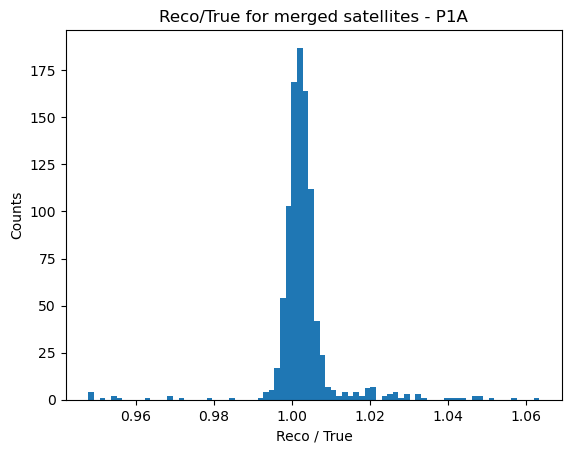

In [139]:
x_ = merged_df.energy.to_numpy()
y_ = merged_df.kin_energy.to_numpy()

plt.hist(np.divide(x_,y_), bins = 80)
plt.xlabel("Reco / True")
plt.ylabel("Counts")
plt. ticklabel_format(style='plain')
plt.title("Reco/True for merged satellites - P1A")
plt.show()

### now lets do it with the cut tracks instead

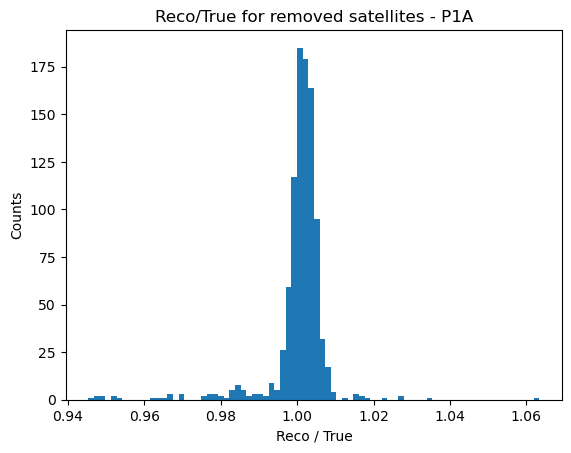

In [142]:
rem_df = pd.merge(remove_cut_tracks[0], summed_E, on='event')

x_ = rem_df.energy.to_numpy()
y_ = rem_df.kin_energy.to_numpy()

plt.hist(np.divide(x_,y_), bins = 80)
plt.xlabel("Reco / True")
plt.ylabel("Counts")
plt. ticklabel_format(style='plain')
plt.title("Reco/True for removed satellites - P1A")
plt.show()

In [6]:
# get positron events
pos_events = positron_ports(folder_paths)

Loading positrons from ../FOM_merge&fit/75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from ../FOM_merge&fit/75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from ../FOM_merge&fit/75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976


In [8]:
# select only events in which events have positrons
rem_sig_data = remove_cut_tracks[0][remove_cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
rem_bck_data = remove_cut_tracks[0][~remove_cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]


# merged version

merg_sig_data = merge_cut_tracks[0][merge_cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
merg_bck_data = merge_cut_tracks[0][~merge_cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

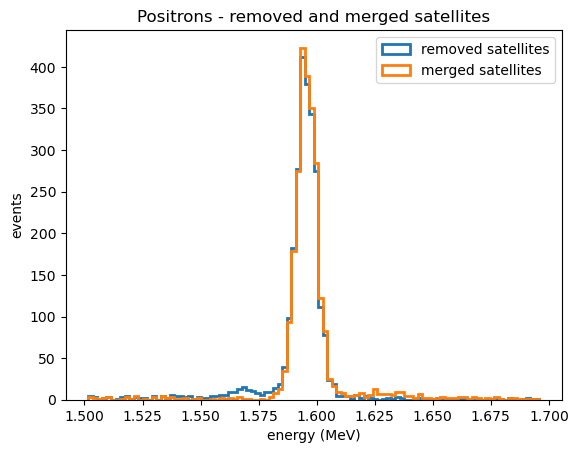

In [10]:
hist, edges, patches = func.plot_hist(rem_sig_data, binning = 100, title='Positrons - removed satellites', log = False, data = True, label = 'removed satellites', fill = False)
hist, edges, patches = func.plot_hist(merg_sig_data, binning = 100, title='Positrons - removed and merged satellites', log = False, data = True, label = 'merged satellites', fill = False)
plt.legend()
plt.show()

### compare the reco from the merged information to the true

Since its the double photo escape peak from the positron, i assume the kinetic energy of these MC events will give us the relevant information.

In [21]:
display(pos_events)
print(pos_events.columns.values)
display(merg_sig_data)

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
302,5080008,42,e+,False,40,399.615417,394.366058,536.815430,0.004905,399.746094,...,0.780250,0.557767,1.590467,-0.0,-0.0,0.0,1.415293,1.324204,conv,annihil
1182,5080032,32,e+,False,30,-166.862320,-370.026581,1148.358154,3.770954,-198.535721,...,-0.247377,-0.461457,1.173200,0.0,0.0,-0.0,0.871628,187.018860,conv,annihil
1375,5080036,37,e+,False,35,-65.955795,324.198029,272.437469,1.781441,-22.099428,...,-1.258216,-0.110806,-0.581811,0.0,-0.0,0.0,0.970557,263.940033,conv,annihil
1757,5080048,18,e+,False,16,394.422913,407.527100,535.740845,0.035130,394.485077,...,0.217861,0.929769,-0.199142,0.0,-0.0,0.0,0.590233,0.248721,conv,annihil
1829,5080050,43,e+,False,41,466.010071,219.144073,487.874298,0.656721,466.172241,...,0.595691,-1.389832,-0.308319,0.0,0.0,0.0,1.114628,0.823723,conv,annihil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
571950,12181188,55,e+,False,53,-317.644165,122.913124,780.973267,2.805562,-227.563492,...,-1.560910,-0.481398,-0.572206,0.0,0.0,0.0,1.293640,398.153534,conv,annihil
572070,12181194,29,e+,False,27,388.389008,145.365875,1089.239014,0.848894,388.548676,...,-0.078389,-0.186970,0.119934,-0.0,-0.0,-0.0,0.051679,3.023956,conv,annihil
573711,12181302,91,e+,False,87,210.304977,-88.572311,528.882324,2.638315,209.844193,...,0.204529,-0.242675,-0.472967,0.0,0.0,0.0,0.254208,50.648548,conv,annihil
574540,12181368,34,e+,False,32,366.878693,391.280914,1094.120483,0.133110,365.349640,...,-0.834090,-0.260838,-0.929550,0.0,-0.0,-0.0,0.863383,4.327487,conv,annihil


['event_id' 'particle_id' 'particle_name' 'primary' 'mother_id'
 'initial_x' 'initial_y' 'initial_z' 'initial_t' 'final_x' 'final_y'
 'final_z' 'final_t' 'initial_volume' 'final_volume' 'initial_momentum_x'
 'initial_momentum_y' 'initial_momentum_z' 'final_momentum_x'
 'final_momentum_y' 'final_momentum_z' 'kin_energy' 'length'
 'creator_proc' 'final_proc']


,event,trackID,energy,length,numb_of_voxels,numb_of_hits,numb_of_tracks,x_min,y_min,z_min,...,blob2_x,blob2_y,blob2_z,eblob1,eblob2,ovlp_blob_energy,vox_size_x,vox_size_y,vox_size_z,PORT
737,5080582,0,1.597251,142.007874,59,6551,1,296.675,-46.325,681.238031,...,337.279082,56.812115,714.750819,0.391053,0.238712,0.0,14.142857,14.500000,13.223831,1a
854,5080676,0,1.594962,141.841206,50,7768,1,179.675,146.675,453.319420,...,273.088557,157.066900,509.242530,0.625310,0.377647,0.0,14.428571,14.666667,13.097077,1a
984,1740022,0,1.595983,240.220791,71,7411,1,187.675,-35.325,409.113469,...,196.685108,54.418912,425.195124,0.514368,0.456328,0.0,13.800000,14.571429,13.871316,1a
1300,1740272,0,1.585759,96.603199,52,7973,1,-188.325,53.675,411.501398,...,-118.512245,62.872010,445.278366,0.451501,0.414708,0.0,13.166667,12.833333,13.914674,1a
1637,1740538,0,1.601273,193.444398,49,7205,1,-103.325,-249.325,453.332480,...,-91.482329,-242.297144,508.823884,0.589608,0.299892,0.0,14.090909,14.000000,13.106973,1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658476,14820972,0,1.599220,234.859839,58,6300,1,141.675,-246.325,841.829888,...,147.839494,-233.666790,870.039122,0.537754,0.368148,0.0,14.714286,14.222222,14.370326,2a
658487,14821002,0,1.597759,152.704345,55,6507,1,-250.325,-64.325,1033.027275,...,-228.022302,55.031051,1085.076712,0.305187,0.132411,0.0,13.500000,14.111111,13.538000,2a
658675,12180240,0,1.593503,168.933124,59,7329,1,247.675,13.675,810.576047,...,287.754545,23.109780,818.112728,0.430172,0.261936,0.0,14.714286,15.000000,13.402069,2a
658853,12180756,0,1.597874,84.486164,43,8744,1,49.675,-137.325,322.404338,...,95.135160,-112.447335,327.540984,0.254408,0.105188,0.0,13.500000,13.800000,13.682209,2a


In [ ]:
# load full MC


In [32]:
merg_sig_np = merg_sig_data.event.to_numpy()

print("reco information")
print(merg_sig_np[0])
print(merg_sig_data.iloc[0]['energy'])
print("")
print("True information")
display(pos_events[pos_events.event_id == merg_sig_np[0]])
reco_true_tuples = []

#for i in range(len(merg_sig_data.index)):
    

reco information
5080582
1.5972505158986894

True information


,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
22812,5080582,40,e+,False,38,344.13269,70.319809,703.978027,1.242562,308.336365,...,-0.105922,-1.027007,0.525102,-0.0,0.0,0.0,0.755024,220.214523,conv,annihil
